# Importing required modules

In [1]:
import pyximport
pyximport.install()
from custom_distance_metric import custom_distance_with_haversine

C:\Users\paras\anaconda3\lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: C:\Parashara\Projects\NUS projects\Sem1\Projects\Home-sweet-home\experiments\KNN\custom_distance_metric.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)

Error compiling Cython file:
------------------------------------------------------------
...
# custom_distance_metric.pyx
from libc.math cimport sin, cos, sqrt, atan2
cimport numpy as np
cimport sklearn.metrics.pairwise as pairwise
        ^
------------------------------------------------------------

custom_distance_metric.pyx:4:8: 'sklearn\metrics\pairwise.pxd' not found

Error compiling Cython file:
------------------------------------------------------------
...
    cdef double a = (sin(dlat * 0.5)) ** 2 + cos(lat1_rad) * cos(lat2_rad) * (sin(dlon * 0.5)) ** 2
    cdef double c = 2 * atan2(sqrt(a), sqrt(1 - a))
    cdef d

ImportError: Building module custom_distance_metric failed: ['Cython.Compiler.Errors.CompileError: C:\\Parashara\\Projects\\NUS projects\\Sem1\\Projects\\Home-sweet-home\\experiments\\KNN\\custom_distance_metric.pyx\n']

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, make_scorer, pairwise_distances
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.data_utils import haversine_distance
import numpy as np
from utils.data_utils import *

C:\Users\paras\anaconda3\lib\site-packages\Cython\Compiler\Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: C:\Parashara\Projects\NUS projects\Sem1\Projects\Home-sweet-home\experiments\KNN\custom_distance_metric.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)

Error compiling Cython file:
------------------------------------------------------------
...
# custom_distance_metric.pyx
from libc.math cimport sin, cos, sqrt, atan2
cimport numpy as np
cimport sklearn.metrics.pairwise as pairwise
        ^
------------------------------------------------------------

custom_distance_metric.pyx:4:8: 'sklearn\metrics\pairwise.pxd' not found

Error compiling Cython file:
------------------------------------------------------------
...
    cdef double a = (sin(dlat * 0.5)) ** 2 + cos(lat1_rad) * cos(lat2_rad) * (sin(dlon * 0.5)) ** 2
    cdef double c = 2 * atan2(sqrt(a), sqrt(1 - a))
    cdef d

ImportError: Building module custom_distance_metric failed: ['Cython.Compiler.Errors.CompileError: C:\\Parashara\\Projects\\NUS projects\\Sem1\\Projects\\Home-sweet-home\\experiments\\KNN\\custom_distance_metric.pyx\n']

# Experiments to run with knn

This notebook contains 2 experiments using knn:
1. Vanilla KNN by passing our entire dataset
2. Custom KNN where we consider Haversine distance in place of regular euclidian distance since we have the latitude and longitude values

First we will try the Vanilla KNN with multiple K values and use the best K value in the second experiment

# Loading the cleaned dataset

In [2]:
datasets_path = "../../datasets/final"
train_path = f"{datasets_path}/train_clean.csv"
test_path = f"{datasets_path}/test_clean.csv"

#load dataframe
train_df = pd.read_csv(train_path)
X_test = pd.read_csv(test_path)

In [3]:
#split the train df into train and val
y = train_df['monthly_rent']
X = train_df.drop(columns=['monthly_rent'])


In [4]:
# split it into train and val datasets from the train_df
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
X_train.head()

,rent_approval_date,flat_type,floor_area_sqm,lease_commence_date,latitude,longitude,distance_to_nearest_existing_mrt,distance_to_nearest_planned_mrt,distance_to_nearest_school,distance_to_nearest_mall,...,town_pasir ris,town_punggol,town_queenstown,town_sembawang,town_sengkang,town_serangoon,town_tampines,town_toa payoh,town_woodlands,town_yishun
49578,0.835346,3,0.215470,0.226415,1.366618,103.847867,0.154874,0.044459,0.156739,0.246589,...,0,0,0,0,0,0,0,0,0,0
50763,0.366630,4,0.325967,0.867925,1.404421,103.907861,0.250359,0.060236,0.131790,0.277809,...,0,1,0,0,0,0,0,0,0,0
24147,0.198683,4,0.386740,0.566038,1.350082,103.698395,0.556430,0.016799,0.175574,0.071191,...,0,0,0,0,0,0,0,0,0,0
13290,0.566411,4,0.276243,0.377358,1.349937,103.869563,0.070570,0.245198,0.067051,0.121983,...,0,0,0,0,0,1,0,0,0,0
17890,0.098793,5,0.491713,0.622642,1.445664,103.819022,0.146773,0.910559,0.093840,0.122580,...,0,0,0,1,0,0,0,0,0,0


In [6]:
y_train.head()

49578    2600.0
50763    2850.0
24147    2100.0
13290    3350.0
17890    2750.0
Name: monthly_rent, dtype: float64

# 1. Vanilla KNN


## 1.1 Elbow curve to find out a good value for k

In [49]:
rms_values = []

start = 5
end = 300
step = 5
k_values = list(range(start, end, step))

for i in tqdm(k_values):
    knn_regressor = KNeighborsRegressor(n_neighbors=i)
    knn_regressor.fit(X_train, y_train)
    y_pred = knn_regressor.predict(X_val)

    # Evaluate the model using Mean Squared Error
    mse = mean_squared_error(y_val, y_pred)
    rms_values.append(mse ** 0.5)

100%|██████████| 59/59 [00:45<00:00,  1.30it/s]


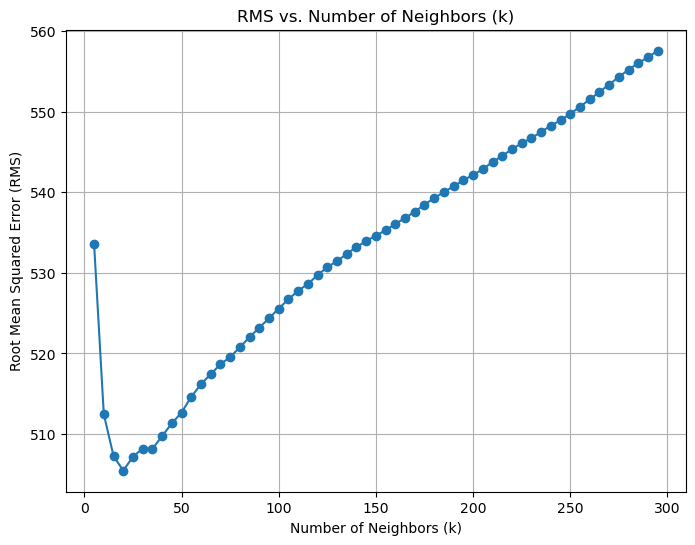

In [51]:
# plotting the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, rms_values, marker='o', linestyle='-')
plt.title('RMS vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Root Mean Squared Error (RMS)')
plt.grid(True)
plt.show()

## 1.2 Doing grid search on other parameters keeping the best k fixed

In [ ]:
# Doing grid search
param_grid = {
    'n_neighbors': [15, 20, 25],  # Steps of 10 from 10 to 300
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [30, 40],  # Adjust as needed
    'p': [1, 2],  # For Manhattan and Euclidean distances
}

# Create the KNN regressor
knn_regressor = KNeighborsRegressor()

# Define the scoring metric (MSE)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Create the GridSearchCV object with verbose logging
grid_search = GridSearchCV(knn_regressor, param_grid, scoring=mse_scorer, cv=5, verbose=3)

# Fit the model to the data (X_train, y_train)
grid_search.fit(X_train, y_train)

# Get the best estimator (model)
best_knn_regressor = grid_search.best_estimator_

# Make predictions on the validation data
y_pred = best_knn_regressor.predict(X_val)

# Calculate the Root Mean Squared Error (RMSE)
rms = mean_squared_error(y_val, y_pred) ** 0.5

# Print the best hyperparameters and RMSE
print("Best Hyperparameters:", grid_search.best_params_)
print(f"Root Mean Squared Error: {rms}")


## Making predictions for the vanilla knn

In [ ]:
y_pred_test = best_knn_regressor.predict(X_test)

save_test_predictions_in_kaggle_format(y_pred_test, "vanilla", True)

# 2. Custom KNN with Haversine

Here we will use a custom KNN Metric to find euclidean distance for the rest of the points, but haversine only for the latitude and longitude

In [ ]:
'''
# Define a custom distance metric
def custom_distance_with_haversine(X1, X2):
    lat_long_indices = [4, 5]
    remaining_indices = list(filter(lambda i: i not in lat_long_indices, list(range(len(X1)))))

    #convert to np arrays
    lat_long_indices = np.array(lat_long_indices)
    remaining_indices = np.array(remaining_indices)

    # Calculate the Haversine distance for latitude and longitude columns
    lat_X1, long_X1 = X1[lat_long_indices]
    lat_X2, long_X2 = X2[lat_long_indices]
    haversine_dist = haversine_distance(lat_X1, long_X1, lat_X2, long_X2) / 1000  # to get distance in km
    haversine_dist = np.array([haversine_dist]).reshape((1, -1))

    # Calculate the Euclidean distance for all columns
    X1_rem = X1[remaining_indices].reshape((1, -1))
    X2_rem = X2[remaining_indices].reshape((1, -1))

    euclidean_dist = pairwise_distances(X1_rem, X2_rem, metric='euclidean')

    # Combine the two distance matrices
    combined_dist = euclidean_dist + haversine_dist

    return combined_dist[0, 0]

'''

In [ ]:
#TODO.x use the best params here
# Create the KNN Regressor with the custom distance metric
knn_regressor = KNeighborsRegressor(n_neighbors=5, metric=custom_distance_with_haversine)

# Fit and use the KNN Regressor as usual
print(f"Fitting the Custom KNN")
knn_regressor.fit(X_train, y_train)

print(f"Making val predictions")
y_pred = knn_regressor.predict(X_val)

# Calculate the Root Mean Squared Error (RMSE)
rms = mean_squared_error(y_val, y_pred) ** 0.5

print(f"The RMS values with haversine implementation is {rms}")

Fitting the Custom KNN
Making val predictions


# Making predictions for the Haversine KNN

In [ ]:
y_pred_test = best_knn_regressor.predict(X_test)

save_test_predictions_in_kaggle_format(y_pred_test, "haversine", True)